### Download all the packages needed.

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium --yes
import folium

from scipy.spatial import distance_matrix

print('Libraries imported.')

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

<a id='item1'></a>

## 1. Download and Explore JSON Dataset for NYC

In [2]:
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
#print('Data downloaded!')

#### Load and take a quick look at the data. Extract the list of the neighborhoods from the features key.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a dataframe, and add each neighborhood as a row to the dataframe.

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Get the latitude and longitude of New York City.

In [5]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

## 2. Use the Foursquare location data to search restaurants in the neighborhoods.

#### Specify Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'EMHX5JAVRBV4Y23CFRRNG4JMHSWYG5OCFHFPGLN1WR1NY5IF' # your Foursquare ID
CLIENT_SECRET = 'K4CMYPKKPVBSEVMQV5GUEFJI2PJRO20Z52AV1Z1SRV3CKNGM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EMHX5JAVRBV4Y23CFRRNG4JMHSWYG5OCFHFPGLN1WR1NY5IF
CLIENT_SECRET:K4CMYPKKPVBSEVMQV5GUEFJI2PJRO20Z52AV1Z1SRV3CKNGM


#### Get the name, latitude and longitude values of the first neighborhood

In [7]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


#### Create the GET request URL

In [8]:
radius=500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query=restaurant'.format(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius)
url

'https://api.foursquare.com/v2/venues/search?client_id=EMHX5JAVRBV4Y23CFRRNG4JMHSWYG5OCFHFPGLN1WR1NY5IF&client_secret=K4CMYPKKPVBSEVMQV5GUEFJI2PJRO20Z52AV1Z1SRV3CKNGM&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&query=restaurant'

#### Send the first GET request and examine the results

In [9]:
results = requests.get(url).json()['response']
results

{'venues': [{'id': '508af256e4b0578944c87392',
   'name': 'Cooler Runnings Jamaican Restaurant Inc',
   'location': {'address': '1802 Nereid Ave',
    'crossStreet': 'Wickham',
    'lat': 40.89827622104366,
    'lng': -73.85038105139019,
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.89827622104366,
      'lng': -73.85038105139019}],
    'distance': 479,
    'postalCode': '10466',
    'cc': 'US',
    'city': 'Bronx',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['1802 Nereid Ave (Wickham)',
     'Bronx, NY 10466',
     'United States']},
   'categories': [{'id': '4bf58dd8d48988d144941735',
     'name': 'Caribbean Restaurant',
     'pluralName': 'Caribbean Restaurants',
     'shortName': 'Caribbean',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_',
      'suffix': '.png'},
     'primary': True}],
   'referralId': 'v-1557705142',
   'hasPerk': False},
  {'id': '4f32aa4719836c91c7edd32c',
   'name': 'Cool Running 

In [10]:
nearby_restaurants = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category'])

for i, v in enumerate(results['venues']):
    nearby_restaurants.loc[i] = [neighborhood_name, 
                neighborhood_latitude, 
                neighborhood_longitude, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name'] if len(v['categories'])>0 else 'Not found'] 

nearby_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Cool Running Restaurant,40.898130,-73.848516,Food
2,Wakefield,40.894705,-73.847201,Bay restaurant,40.890850,-73.848860,Not found
3,Wakefield,40.894705,-73.847201,Fort Negril Jamaican Restaurant,40.898318,-73.850442,Food
4,Wakefield,40.894705,-73.847201,Allure Restaurant And Bar,40.892543,-73.852265,Restaurant


#### Create a function to perform the following process to all the neighborhoods in NYC:
    1. Create the request URL for all the restaurants in each neighborhood within a radius of 500 meters.
    2. Make the GET request and acquire the results.
    3. Extract relevant information for each nearby restaurant.
    4. Create a dataframe containing the relevant information for all the nearby restaurants.
    5. Drop the duplicates, which can occur due to a restaurant being searched for more than one neighborhood.

In [11]:
def NeighborhoodRestaurants(names, latitudes, longitudes, radius=500):
    
    neighborhood_restaurants = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category'])
    
    total_rows = 0
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the first API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()['response']
                
        # return only relevant information for each nearby restaurant
        if 'venues' in results.keys():
            for v in results['venues']:
                neighborhood_restaurants.loc[total_rows] = [
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'] if len(v['categories'])>0 else 'Not found']
                total_rows = total_rows + 1

    neighborhood_restaurants.drop_duplicates(inplace=True)
    
    return(neighborhood_restaurants)

#### Create a new dataframe called *newyork_restaurants* and check the size and head of the dataframe.

In [12]:
# type your answer here

newyork_restaurants = NeighborhoodRestaurants(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
print(newyork_restaurants.shape)
newyork_restaurants.head()

(3559, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
0,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Cool Running Restaurant,40.898130,-73.848516,Food
2,Wakefield,40.894705,-73.847201,Bay restaurant,40.890850,-73.848860,Not found
3,Wakefield,40.894705,-73.847201,Fort Negril Jamaican Restaurant,40.898318,-73.850442,Food
4,Wakefield,40.894705,-73.847201,Allure Restaurant And Bar,40.892543,-73.852265,Restaurant


#### Move neighborhood column to the first column

In [13]:
fixed_columns = [newyork_restaurants.columns[-1]] + list(newyork_restaurants.columns[:3]) + list(newyork_restaurants.columns[-4:-1])
newyork_restaurants_adjusted = newyork_restaurants[fixed_columns]

newyork_restaurants_adjusted.head()

,Restaurant Category,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Restaurant Latitude,Restaurant Longitude
0,Caribbean Restaurant,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381
1,Food,Wakefield,40.894705,-73.847201,Cool Running Restaurant,40.898130,-73.848516
2,Not found,Wakefield,40.894705,-73.847201,Bay restaurant,40.890850,-73.848860
3,Food,Wakefield,40.894705,-73.847201,Fort Negril Jamaican Restaurant,40.898318,-73.850442
4,Restaurant,Wakefield,40.894705,-73.847201,Allure Restaurant And Bar,40.892543,-73.852265


## 3. Data Cleaning and Analyzing Each Neighborhood

#### Eliminate "Restaurant Categories" that are not actually restaurants

In [14]:
newyork_restaurants_adjusted = newyork_restaurants_adjusted[~newyork_restaurants_adjusted['Restaurant Category'].isin(['Arcade',
                                                                                                                       'Automotive Shop',
                                                                                                                       'Building',
                                                                                                                       'Business Service',
                                                                                                                       'College Classroom',
                                                                                                                       'Conference Room',
                                                                                                                       "Dentist's Office",
                                                                                                                       'Design Studio',
                                                                                                                       'Event Space',
                                                                                                                       'Furniture / Home Store',
                                                                                                                       'Garden',
                                                                                                                       'General Entertainment',
                                                                                                                       'Gift Shop',
                                                                                                                       'Grocery Store',
                                                                                                                       'Gym / Fitness Center',
                                                                                                                       'Historic Site',
                                                                                                                       'Home Service',
                                                                                                                       'Hotel',
                                                                                                                       'Housing Development',
                                                                                                                       'Jazz Club',
                                                                                                                       'Karaoke Bar',
                                                                                                                       'Kitchen Supply Store',
                                                                                                                       'Laundry Service',
                                                                                                                       'Metro Station',
                                                                                                                       'Miscellaneous Shop',
                                                                                                                       'Music Venue',
                                                                                                                       'Non-Profit',
                                                                                                                       'Not found',
                                                                                                                       'Office',
                                                                                                                       'Other Event',
                                                                                                                       'Other Great Outdoors',
                                                                                                                       'Other Nightlife',
                                                                                                                       'Racetrack',
                                                                                                                       'Scenic Lookout',
                                                                                                                       'Shopping Mall',
                                                                                                                       'Tanning Salon',
                                                                                                                       'Tech Startup',
                                                                                                                       'Theater'])]

#### Rename some of the restaurant types

In [15]:
newyork_restaurants_adjusted.replace(['African Restaurant','American Restaurant','Asian Restaurant','Bakery','Bar','Chinese Restaurant','Eastern European Restaurant',
                                     'Latin American Restaurant','Mediterranean Restaurant','Middle Eastern Restaurant','Pub','Restaurant','South American Restaurant','Indian Restaurant'],
                                     ['Generic African Restaurant','Generic American Restaurant','Generic Asian Restaurant','Generic Bakery','Generic Bar','Generic Chinese Restaurant',
                                      'Generic Eastern European Restaurant','Generic Latin American Restaurant','Generic Mediterranean Restaurant','Generic Middle Eastern Restaurant',
                                      'Generic Pub','Unknown Type Restaurant','Generic South American Restaurant','Generic Indian Restaurant'], inplace=True)

#### Combine some of the same or similar restaurant types

In [16]:
newyork_restaurants_adjusted.replace(['Coffee Shop','Cuban Restaurant','Deli / Bodega','Dim Sum Restaurant','Diner','Falafel Restaurant',
                                      'Dessert Shop','Fish & Chips Shop','Food','Food & Drink Shop','Food Court','Kosher Restaurant','Lounge',
                                      'Paella Restaurant','Persian Restaurant','Sushi Restaurant','Tapas Restaurant'],
                                     ['Café','Caribbean Restaurant','Bistro','Cantonese Restaurant','Bistro','Sandwich Place','Bakery',
                                      'Fast Food Restaurant','Unknown Type Restaurant','Fast Food Restaurant','Fast Food Restaurant',
                                      'Jewish Restaurant','Generic Bar','Spanish Restaurant','Generic Middle Eastern Restaurant','Japanese Restaurant','Spanish Restaurant'], inplace=True)

#### Group all the restaurants by the neighborhood they are located in and their categories

In [17]:
newyork_restaurants_grouped_count = newyork_restaurants_adjusted.groupby(['Neighborhood','Restaurant Category'])[['Restaurant']].count()
newyork_restaurants_grouped_count.head(10)

Restaurant
Neighborhood  Restaurant Category                         
Allerton      Generic American Restaurant                1
              Generic Bakery                             1
              Mexican Restaurant                         1
              Spanish Restaurant                         2
              Unknown Type Restaurant                    1
Annadale      Pizza Place                                2
Arden Heights Pizza Place                                1
Arrochar      Generic Mediterranean Restaurant           1
              Italian Restaurant                         2
Arverne       Pizza Place                                1

#### See how many types of restaurants are available

In [18]:
print('There are {} unique categories.'.format(len(newyork_restaurants_adjusted['Restaurant Category'].unique())))

There are 101 unique categories.


#### Create one hot coding of restaurant types for each neighborhood

In [19]:
# one hot encoding
newyork_restaurants_onehot = pd.get_dummies(newyork_restaurants_adjusted[['Restaurant Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_restaurants_onehot['Neighborhood'] = newyork_restaurants_adjusted['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_restaurants_onehot.columns[-34]] + list(newyork_restaurants_onehot.columns[:-34]) + list(newyork_restaurants_onehot.columns[-33:])
newyork_restaurants_onehot = newyork_restaurants_onehot[fixed_columns]

newyork_restaurants_onehot.head()

,New American Restaurant,Arepa Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Czech Restaurant,Dive Bar,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Generic African Restaurant,Generic American Restaurant,Generic Asian Restaurant,Generic Bakery,Generic Bar,Generic Chinese Restaurant,Generic Eastern European Restaurant,Generic Indian Restaurant,Generic Latin American Restaurant,Generic Mediterranean Restaurant,Generic Middle Eastern Restaurant,Generic Pub,Generic South American Restaurant,German Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mexican Restaurant,Moroccan Restaurant,Neighborhood,Nightclub,Noodle House,Pakistani Restaurant,Peruvian Restaurant,Pie Shop,Pizza Place,Polish Restaurant,Russian Restaurant,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Steakhouse,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Ukrainian Restaurant,Unknown Type Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [20]:
newyork_restaurants_onehot.shape

(3401, 101)

#### Group rows by neighborhood and obtain the frequency of each restaurant type

In [21]:
newyork_restaurants_grouped = newyork_restaurants_onehot.groupby('Neighborhood').sum().reset_index()

# calculate the total number of restaurants in each neighborhood
newyork_restaurants_grouped['Total'] = newyork_restaurants_grouped.sum(axis=1)

newyork_restaurants_grouped.head(10)

,Neighborhood,New American Restaurant,Arepa Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Czech Restaurant,Dive Bar,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Generic African Restaurant,Generic American Restaurant,Generic Asian Restaurant,Generic Bakery,Generic Bar,Generic Chinese Restaurant,Generic Eastern European Restaurant,Generic Indian Restaurant,Generic Latin American Restaurant,Generic Mediterranean Restaurant,Generic Middle Eastern Restaurant,Generic Pub,Generic South American Restaurant,German Restaurant,Gourmet Shop,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mexican Restaurant,Moroccan Restaurant,Nightclub,Noodle House,Pakistani Restaurant,Peruvian Restaurant,Pie Shop,Pizza Place,Polish Restaurant,Russian Restaurant,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Steakhouse,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Ukrainian Restaurant,Unknown Type Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yemeni Restaurant,Total
0,Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6
1,Annadale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,Arden Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,Arverne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Astoria,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,3,0,0,0,0,1,0,0,1,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,30
6,Astoria Heights,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3
7,Auburndale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
8,Bath Beach,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,30
9,Battery Park City,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,22


In [22]:
newyork_restaurants_grouped.shape

(264, 102)

## 4. Creating a new *recommender* dataframe to hold features needed for restaurant location recommender.

#### Create the dataframe named recommender and put in total number of restaurants in the neighborhood as the first feature (first column)

In [23]:
# create a new empty dataframe
recommender = pd.DataFrame()
recommender['Neighborhood'] = neighborhoods['Neighborhood']

# create the first feature in recommender, which is the total number of restaurants in the neighborhood
recommender['Total Restaurant'] = newyork_restaurants_grouped['Total']
recommender['Total Restaurant'].fillna(0.0, inplace=True)

recommender.head()

,Neighborhood,Total Restaurant
0,Wakefield,6.0
1,Co-op City,2.0
2,Eastchester,1.0
3,Fieldston,3.0
4,Riverdale,1.0


In [24]:
recommender.shape

(306, 2)

#### Suppose a person wants to open a new Italian restaurant in NYC, we want to include the distribution of Italian restaurants in NYC neighborhoods.

In [25]:
desired_type = 'Italian Restaurant'
recommender[desired_type] = newyork_restaurants_grouped[desired_type]
recommender[desired_type].fillna(0.0, inplace=True)

recommender.head()

,Neighborhood,Total Restaurant,Italian Restaurant
0,Wakefield,6.0,0.0
1,Co-op City,2.0,0.0
2,Eastchester,1.0,0.0
3,Fieldston,3.0,2.0
4,Riverdale,1.0,0.0


#### Calculate the distances between neighborhoods and correlate the neighborhoods based on their distances.

In [26]:
neighborhoods_matrix = neighborhoods[['Latitude','Longitude']].values
neighborhoods_distance_matrix = distance_matrix(neighborhoods_matrix, neighborhoods_matrix)

neighborhoods_distance_matrix

array([[0.        , 0.02673134, 0.02066992, ..., 0.29479646, 0.17000679,
        0.363258  ],
       [0.02673134, 0.        , 0.01343187, ..., 0.27064158, 0.16539791,
        0.35978343],
       [0.02066992, 0.01343187, 0.        , ..., 0.28307107, 0.17653736,
        0.37082949],
       ...,
       [0.29479646, 0.27064158, 0.28307107, ..., 0.        , 0.23073143,
        0.3158289 ],
       [0.17000679, 0.16539791, 0.17653736, ..., 0.23073143, 0.        ,
        0.19438557],
       [0.363258  , 0.35978343, 0.37082949, ..., 0.3158289 , 0.19438557,
        0.        ]])

In [27]:
neighborhoods_distance_matrix.shape

(306, 306)

#### Inverse all the distances so that the further each neighborhood is to the current neighborhood, the smaller the impact of restaurants in that neighborhood is to the current neighborhood. Remember to convert the diagonal to 100 to replace infinity in inverse.

In [28]:
neighborhoods_impact_matrix = np.reciprocal(neighborhoods_distance_matrix)
for i in range(neighborhoods_impact_matrix.shape[0]):
    neighborhoods_impact_matrix[i,i]=100.0
    
neighborhoods_impact_matrix

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.


array([[100.        ,  37.40927129,  48.37949057, ...,   3.392171  ,
          5.88211802,   2.75286435],
       [ 37.40927129, 100.        ,  74.4497814 , ...,   3.69492379,
          6.04602548,   2.77944983],
       [ 48.37949057,  74.4497814 , 100.        , ...,   3.53268172,
          5.66452344,   2.69665719],
       ...,
       [  3.392171  ,   3.69492379,   3.53268172, ..., 100.        ,
          4.33404328,   3.16627137],
       [  5.88211802,   6.04602548,   5.66452344, ...,   4.33404328,
        100.        ,   5.14441492],
       [  2.75286435,   2.77944983,   2.69665719, ...,   3.16627137,
          5.14441492, 100.        ]])

#### Calculate the impact score of Italian restaurant in other neighborhoods to Italian restaurants in the current neighborhoods, by multiplying the impact matrix with the number of Italian restaurants in that neighborhood.

In [29]:
neighborhoods_impact_matrix = np.multiply(neighborhoods_impact_matrix,np.asmatrix(recommender[desired_type].values))
neighborhoods_impact_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

#### Convert the distance matrix into a dataframe, corresponding each neighborhoods to all the other NYC neighborhoods.

In [30]:
distance_frame = pd.DataFrame(neighborhoods_impact_matrix, columns=['Impact from '+recommender.loc[i,'Neighborhood'] for i in range(neighborhoods_distance_matrix.shape[0])])
distance_frame.head()

,Impact from Wakefield,Impact from Co-op City,Impact from Eastchester,Impact from Fieldston,Impact from Riverdale,Impact from Kingsbridge,Impact from Marble Hill,Impact from Woodlawn,Impact from Norwood,Impact from Williamsbridge,Impact from Baychester,Impact from Pelham Parkway,Impact from City Island,Impact from Bedford Park,Impact from University Heights,Impact from Morris Heights,Impact from Fordham,Impact from East Tremont,Impact from West Farms,Impact from High Bridge,Impact from Melrose,Impact from Mott Haven,Impact from Port Morris,Impact from Longwood,Impact from Hunts Point,Impact from Morrisania,Impact from Soundview,Impact from Clason Point,Impact from Throgs Neck,Impact from Country Club,Impact from Parkchester,Impact from Westchester Square,Impact from Van Nest,Impact from Morris Park,Impact from Belmont,Impact from Spuyten Duyvil,Impact from North Riverdale,Impact from Pelham Bay,Impact from Schuylerville,Impact from Edgewater Park,Impact from Castle Hill,Impact from Olinville,Impact from Pelham Gardens,Impact from Concourse,Impact from Unionport,Impact from Edenwald,Impact from Bay Ridge,Impact from Bensonhurst,Impact from Sunset Park,Impact from Greenpoint,Impact from Gravesend,Impact from Brighton Beach,Impact from Sheepshead Bay,Impact from Manhattan Terrace,Impact from Flatbush,Impact from Crown Heights,Impact from East Flatbush,Impact from Kensington,Impact from Windsor Terrace,Impact from Prospect Heights,Impact from Brownsville,Impact from Williamsburg,Impact from Bushwick,Impact from Bedford Stuyvesant,Impact from Brooklyn Heights,Impact from Cobble Hill,Impact from Carroll Gardens,Impact from Red Hook,Impact from Gowanus,Impact from Fort Greene,Impact from Park Slope,Impact from Cypress Hills,Impact from East New York,Impact from Starrett City,Impact from Canarsie,Impact from Flatlands,Impact from Mill Island,Impact from Manhattan Beach,Impact from Coney Island,Impact from Bath Beach,Impact from Borough Park,Impact from Dyker Heights,Impact from Gerritsen Beach,Impact from Marine Park,Impact from Clinton Hill,Impact from Sea Gate,Impact from Downtown,Impact from Boerum Hill,Impact from Prospect Lefferts Gardens,Impact from Ocean Hill,Impact from City Line,Impact from Bergen Beach,Impact from Midwood,Impact from Prospect Park South,Impact from Georgetown,Impact from East Williamsburg,Impact from North Side,Impact from South Side,Impact from Ocean Parkway,Impact from Fort Hamilton,Impact from Chinatown,Impact from Washington Heights,Impact from Inwood,Impact from Hamilton Heights,Impact from Manhattanville,Impact from Central Harlem,Impact from East Harlem,Impact from Upper East Side,Impact from Yorkville,Impact from Lenox Hill,Impact from Roosevelt Island,Impact from Upper West Side,Impact from Lincoln Square,Impact from Clinton,Impact from Midtown,Impact from Murray Hill,Impact from Chelsea,Impact from Greenwich Village,Impact from East Village,Impact from Lower East Side,Impact from Tribeca,Impact from Little Italy,Impact from Soho,Impact from West Village,Impact from Manhattan Valley,Impact from Morningside Heights,Impact from Gramercy,Impact from Battery Park City,Impact from Financial District,Impact from Astoria,Impact from Woodside,Impact from Jackson Heights,Impact from Elmhurst,Impact from Howard Beach,Impact from Corona,Impact from Forest Hills,Impact from Kew Gardens,Impact from Richmond Hill,Impact from Flushing,Impact from Long Island City,Impact from Sunnyside,Impact from East Elmhurst,Impact from Maspeth,Impact from Ridgewood,Impact from Glendale,Impact from Rego Park,Impact from Woodhaven,Impact from Ozone Park,Impact from South Ozone Park,Impact from College Point,Impact from Whitestone,Impact from Bayside,Impact from Auburndale,Impact from Little Neck,Impact from Douglaston,Impact from Glen Oaks,Impact from Bellerose,Impact from Kew Gardens Hills,Impact from Fresh Meadows,Impact from Briarwood,Impact from Jamaica Center,Impact from Oakland Gardens,Impact from Queens Village,Impact from

#### Calculate the total impact values for Italian restaurants in the entire NYC to the present neighborhood.

In [31]:
distance_frame['Total Impact'] = distance_frame.sum(axis=1)
distance_frame.head()

,Impact from Wakefield,Impact from Co-op City,Impact from Eastchester,Impact from Fieldston,Impact from Riverdale,Impact from Kingsbridge,Impact from Marble Hill,Impact from Woodlawn,Impact from Norwood,Impact from Williamsbridge,Impact from Baychester,Impact from Pelham Parkway,Impact from City Island,Impact from Bedford Park,Impact from University Heights,Impact from Morris Heights,Impact from Fordham,Impact from East Tremont,Impact from West Farms,Impact from High Bridge,Impact from Melrose,Impact from Mott Haven,Impact from Port Morris,Impact from Longwood,Impact from Hunts Point,Impact from Morrisania,Impact from Soundview,Impact from Clason Point,Impact from Throgs Neck,Impact from Country Club,Impact from Parkchester,Impact from Westchester Square,Impact from Van Nest,Impact from Morris Park,Impact from Belmont,Impact from Spuyten Duyvil,Impact from North Riverdale,Impact from Pelham Bay,Impact from Schuylerville,Impact from Edgewater Park,Impact from Castle Hill,Impact from Olinville,Impact from Pelham Gardens,Impact from Concourse,Impact from Unionport,Impact from Edenwald,Impact from Bay Ridge,Impact from Bensonhurst,Impact from Sunset Park,Impact from Greenpoint,Impact from Gravesend,Impact from Brighton Beach,Impact from Sheepshead Bay,Impact from Manhattan Terrace,Impact from Flatbush,Impact from Crown Heights,Impact from East Flatbush,Impact from Kensington,Impact from Windsor Terrace,Impact from Prospect Heights,Impact from Brownsville,Impact from Williamsburg,Impact from Bushwick,Impact from Bedford Stuyvesant,Impact from Brooklyn Heights,Impact from Cobble Hill,Impact from Carroll Gardens,Impact from Red Hook,Impact from Gowanus,Impact from Fort Greene,Impact from Park Slope,Impact from Cypress Hills,Impact from East New York,Impact from Starrett City,Impact from Canarsie,Impact from Flatlands,Impact from Mill Island,Impact from Manhattan Beach,Impact from Coney Island,Impact from Bath Beach,Impact from Borough Park,Impact from Dyker Heights,Impact from Gerritsen Beach,Impact from Marine Park,Impact from Clinton Hill,Impact from Sea Gate,Impact from Downtown,Impact from Boerum Hill,Impact from Prospect Lefferts Gardens,Impact from Ocean Hill,Impact from City Line,Impact from Bergen Beach,Impact from Midwood,Impact from Prospect Park South,Impact from Georgetown,Impact from East Williamsburg,Impact from North Side,Impact from South Side,Impact from Ocean Parkway,Impact from Fort Hamilton,Impact from Chinatown,Impact from Washington Heights,Impact from Inwood,Impact from Hamilton Heights,Impact from Manhattanville,Impact from Central Harlem,Impact from East Harlem,Impact from Upper East Side,Impact from Yorkville,Impact from Lenox Hill,Impact from Roosevelt Island,Impact from Upper West Side,Impact from Lincoln Square,Impact from Clinton,Impact from Midtown,Impact from Murray Hill,Impact from Chelsea,Impact from Greenwich Village,Impact from East Village,Impact from Lower East Side,Impact from Tribeca,Impact from Little Italy,Impact from Soho,Impact from West Village,Impact from Manhattan Valley,Impact from Morningside Heights,Impact from Gramercy,Impact from Battery Park City,Impact from Financial District,Impact from Astoria,Impact from Woodside,Impact from Jackson Heights,Impact from Elmhurst,Impact from Howard Beach,Impact from Corona,Impact from Forest Hills,Impact from Kew Gardens,Impact from Richmond Hill,Impact from Flushing,Impact from Long Island City,Impact from Sunnyside,Impact from East Elmhurst,Impact from Maspeth,Impact from Ridgewood,Impact from Glendale,Impact from Rego Park,Impact from Woodhaven,Impact from Ozone Park,Impact from South Ozone Park,Impact from College Point,Impact from Whitestone,Impact from Bayside,Impact from Auburndale,Impact from Little Neck,Impact from Douglaston,Impact from Glen Oaks,Impact from Bellerose,Impact from Kew Gardens Hills,Impact from Fresh Meadows,Impact from Briarwood,Impact from Jamaica Center,Impact from Oakland Gardens,Impact from Queens Village,Impact from

#### Add the total Italian Impact to the *recommender* dataframe

In [32]:
recommender['Total '+desired_type.split()[0]+' Impact'] = distance_frame['Total Impact']
recommender.head()

,Neighborhood,Total Restaurant,Italian Restaurant,Total Italian Impact
0,Wakefield,6.0,0.0,1397.202058
1,Co-op City,2.0,0.0,1557.055746
2,Eastchester,1.0,0.0,1276.985371
3,Fieldston,3.0,2.0,1825.302732
4,Riverdale,1.0,0.0,2055.595213


#### Repeat the above process taking into account all types of restaurants. Generally, the more restaurants currently available in the surrounding area, the more difficult for a new restaurant to sustain.

In [33]:
neighborhoods_impact_matrix_total = np.reciprocal(neighborhoods_distance_matrix)
for i in range(neighborhoods_impact_matrix_total.shape[0]):
    neighborhoods_impact_matrix_total[i,i]=100.0
    
neighborhoods_impact_matrix_total = np.multiply(neighborhoods_impact_matrix_total,np.asmatrix(recommender['Total Restaurant'].values))

distance_frame_total = pd.DataFrame(neighborhoods_impact_matrix_total, columns=['Impact from '+recommender.loc[i,'Neighborhood'] for i in range(neighborhoods_distance_matrix.shape[0])])

distance_frame_total['Total Impact'] = distance_frame_total.sum(axis=1)

recommender['Total Impact'] = distance_frame_total['Total Impact']
recommender.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.


,Neighborhood,Total Restaurant,Italian Restaurant,Total Italian Impact,Total Impact
0,Wakefield,6.0,0.0,1397.202058,25946.503769
1,Co-op City,2.0,0.0,1557.055746,26989.960925
2,Eastchester,1.0,0.0,1276.985371,23080.892665
3,Fieldston,3.0,2.0,1825.302732,26158.998506
4,Riverdale,1.0,0.0,2055.595213,27553.352716


#### Drop the unnecessary layers, normalize the data and calculate the final location suitability score

In [34]:
recommender.drop(['Total Restaurant',desired_type], axis=1, inplace=True)
recommender['Total '+desired_type.split()[0]+' Impact'] = recommender['Total '+desired_type.split()[0]+' Impact']/recommender['Total '+desired_type.split()[0]+' Impact'].max()
recommender['Total Impact'] = recommender['Total Impact']/recommender['Total Impact'].max()

# location suitability score: 0.25*total impact score + 0.75*total Italian impact score
total_impact_weight = 0.25
total_type_impact_weight = 0.75
recommender['Location Suitability Score'] = recommender.apply(lambda x: total_impact_weight*x['Total Impact'] + total_type_impact_weight*x['Total '+desired_type.split()[0]+' Impact'], axis=1)

recommender.head()

,Neighborhood,Total Italian Impact,Total Impact,Location Suitability Score
0,Wakefield,0.460913,0.620981,0.500930
1,Co-op City,0.513646,0.645954,0.546723
2,Eastchester,0.421256,0.552398,0.454041
3,Fieldston,0.602136,0.626066,0.608119
4,Riverdale,0.678106,0.659438,0.673439


This location suitability score is a metric to evaluate preliminarily which neighborhood to locate the new Italian restaurant in. Of course, this is also applicable to all types of restaurants recorded in Foursquare location data.

#### Let's integrate what we have done above into a single function.

In [35]:
def LocationSuitabilityScore(desired_type, neighborhood_data, restaurant_data, total_impact_weight = 0.25, total_type_impact_weight = 0.75):
    # create a new empty dataframe
    recommender = pd.DataFrame()
    recommender['Neighborhood'] = neighborhood_data['Neighborhood']

    # create the first feature in recommender, which is the total number of restaurants in the neighborhood
    recommender['Total Restaurant'] = restaurant_data['Total']
    recommender['Total Restaurant'].fillna(0.0, inplace=True)
    
    # create the column to show the number of desired type restaurants in the neighborhood
    recommender[desired_type] = restaurant_data[desired_type]
    recommender[desired_type].fillna(0.0, inplace=True)
    
    # calculate the distances between neighborhoods and correlate the neighborhoods based on their distances
    neighborhoods_matrix = neighborhood_data[['Latitude','Longitude']].values
    neighborhoods_distance_matrix = distance_matrix(neighborhoods_matrix, neighborhoods_matrix)
    
    # Inverse the distances and compute the impact matrix
    neighborhoods_impact_matrix = np.reciprocal(neighborhoods_distance_matrix)
    for i in range(neighborhoods_impact_matrix.shape[0]):
        neighborhoods_impact_matrix[i,i]=100.0    
    neighborhoods_impact_matrix = np.multiply(neighborhoods_impact_matrix,np.asmatrix(recommender[desired_type].values))
    distance_frame = pd.DataFrame(neighborhoods_impact_matrix, columns=['Impact from '+recommender.loc[i,'Neighborhood'] for i in range(neighborhoods_distance_matrix.shape[0])])
    
    # Calculate the total impact values
    distance_frame['Total Impact'] = distance_frame.sum(axis=1)
    recommender['Total '+desired_type.split()[0]+' Impact'] = distance_frame['Total Impact']
    
    # Repeat the above process for all types of restaurants
    neighborhoods_impact_matrix_total = np.reciprocal(neighborhoods_distance_matrix)
    for i in range(neighborhoods_impact_matrix_total.shape[0]):
        neighborhoods_impact_matrix_total[i,i]=100.0
    neighborhoods_impact_matrix_total = np.multiply(neighborhoods_impact_matrix_total,np.asmatrix(recommender['Total Restaurant'].values))
    distance_frame_total = pd.DataFrame(neighborhoods_impact_matrix_total, columns=['Impact from '+recommender.loc[i,'Neighborhood'] for i in range(neighborhoods_distance_matrix.shape[0])])
    distance_frame_total['Total Impact'] = distance_frame_total.sum(axis=1)
    recommender['Total Impact'] = distance_frame_total['Total Impact']
    
    # Drop the unnecessary layers, normalize the data and calculate the final location suitability score
    recommender.drop(['Total Restaurant',desired_type], axis=1, inplace=True)
    recommender['Total '+desired_type.split()[0]+' Impact'] = recommender['Total '+desired_type.split()[0]+' Impact']/recommender['Total '+desired_type.split()[0]+' Impact'].max()
    recommender['Total Impact'] = recommender['Total Impact']/recommender['Total Impact'].max()

    # Calculate location suitability score
    recommender['Location Suitability Score'] = recommender.apply(lambda x: total_impact_weight*x['Total Impact'] + total_type_impact_weight*x['Total '+desired_type.split()[0]+' Impact'], axis=1)
    
    return(recommender)

#### Let's test the function on another type of restaurant: Vietnamese Restaurant

In [36]:
recommender_vietnamese = LocationSuitabilityScore(desired_type='Vietnamese Restaurant', 
                                                  neighborhood_data=neighborhoods, 
                                                  restaurant_data=newyork_restaurants_grouped, 
                                                  total_impact_weight = 0.25, 
                                                  total_type_impact_weight = 0.75)
recommender_vietnamese

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in reciprocal
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in reciprocal


,Neighborhood,Total Vietnamese Impact,Total Impact,Location Suitability Score
0,Wakefield,0.283177,0.620981,0.367628
1,Co-op City,0.461929,0.645954,0.507935
2,Eastchester,0.290116,0.552398,0.355687
3,Fieldston,0.230861,0.626066,0.329663
4,Riverdale,0.244332,0.659438,0.348108
5,Kingsbridge,0.271292,0.714055,0.381983
6,Marble Hill,0.317549,0.772109,0.431189
7,Woodlawn,0.259589,0.594021,0.343197
8,Norwood,0.325873,0.742156,0.429944
9,Williamsbridge,0.421281,0.750677,0.503630


#### Visualize the distribution of the Location Suitability Score of a new Vietnamese restaurant in NYC

Text(0.5, 0, 'Location Suitability Score')

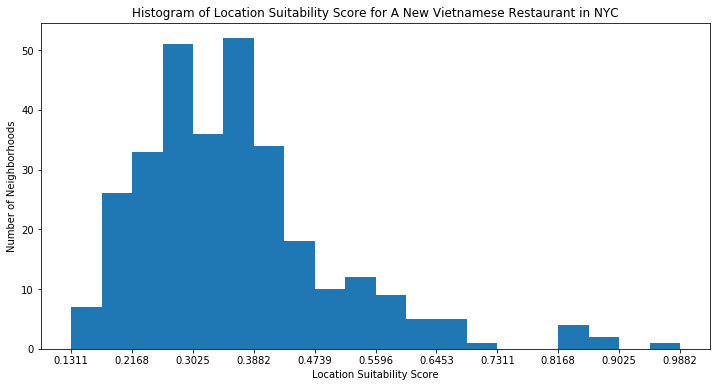

In [37]:
count, bin_edges = np.histogram(recommender_vietnamese['Location Suitability Score'])

recommender_vietnamese['Location Suitability Score'].plot(kind='hist', xticks=bin_edges, bins=20, figsize=(12, 6))

plt.title('Histogram of Location Suitability Score for A New Vietnamese Restaurant in NYC')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Location Suitability Score')

#### Create a choropleth map of Vietnamese Restaurants in New York City (Unsuccessful Part)

In [38]:
vietrestaurant_choropleth_map = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='Mapbox Bright')
newyork_geo = r'newyork_data.json'

desired_type = 'Vietnamese Restaurant'

vietrestaurant_choropleth_map.choropleth(
    geo_data=newyork_geo,
    data=recommender_vietnamese,
    columns=['Neighborhood','Location Suitability Score'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurant Density',
    reset=True
)
vietrestaurant_choropleth_map

/home/jupyterlab/conda/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### Summary
As a consequence, location suitability scores for opening a new Vietnamese restaurant all NYC neighborhoods are shown. This is a preliminary selection of neighborhoods where restaurants should be located. There are of course, quite a few limitations and assumptions for this recommender, which will be discussed in the Discussion section of the report.